In [13]:
# ===============================================================================
# PART 1: SETUP AND DATA LOADING
# ===============================================================================



# Load Data (THIS STEP DEFINES 'df' AND MUST BE EXECUTED)
# ASSUMPTION: The file is named 'download.csv' and is in the same directory.
try:
    df = pd.read_csv('download.csv')
except FileNotFoundError:
    print("ERROR: Please ensure 'download.csv' is in the current working directory.")
    raise # Stops execution if the file is missing
  # Core Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and Diagnostics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor  
print(f"Initial Data Shape: {df.shape}")
print(df.head())

Initial Data Shape: (730, 16)
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit    temp   atemp     hum  windspeed  casual  registered   cnt  
0           2 14.1108 18.1812 80.5833    10.7499     331         654   985  
1           2 14.9026 17.6869 69.6087    16.6521     131         670   801  
2           1  8.0509  9.4703 43.7273    16.6367     120        1229  1349  
3           1  8.2000 10.6061 59.0435    10.7398     108        1454  1562  
4           1  9.3052 11.4635 43.6957    12.5223      82        1518  1600  


In [16]:
# ===============================================================================
# PART 2: DATA QUALITY, CLEANING, AND DERIVED METRICS
# ===============================================================================

# --- 2.1 Data Quality Checks & Cleanup ---

# 1. Missing Values: Check for NaNs. 
print("\nMissing Values Check:")
print(df.isnull().sum())
# COMMENT: Data quality check confirms no missing values are present.

# 2. Drop Identifier/Redundant Columns
# 'instant': Record index, no predictive power.
# 'dteday': Date column, information is already captured by 'yr', 'mnth', 'weekday', etc.
# 'casual' & 'registered': Dropped to prevent data leakage, as 'cnt' = 'casual' + 'registered'.
df.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)
print(f"\nData Shape after dropping leakage/identifier columns: {df.shape}")

# --- 2.2 Categorical Variable Conversion ---

# The following columns are categorical but encoded as integers.
# We must convert them to the 'category' type for proper one-hot encoding.
categorical_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
for col in categorical_vars:
    df[col] = df[col].astype('category')

# COMMENT: Categorical columns converted from int to category/object type.

# --- 2.3 Derived Metrics (New Variables) ---

# 'atemp' is dropped due to its high correlation with 'temp'.
# Keeping both often leads to multicollinearity (VIF > 5-10).
df.drop(columns=['atemp'], inplace=True) 

# COMMENT: 'atemp' (feeling temperature) is dropped due to high multicollinearity with 'temp'.



Missing Values Check:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Data Shape after dropping leakage/identifier columns: (730, 12)


In [20]:
# ===============================================================================
# PART 3: EXPLORATORY DATA ANALYSIS (EDA) & PRE-PROCESSING
# ===============================================================================

# --- 3.1 One-Hot Encoding (Dummy Variables) ---

# Create dummy variables for categorical features using drop_first=True 
# to avoid the Dummy Variable Trap (perfect multicollinearity).
df_dummies = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# Separate Target variable (y) and Feature set (X)
y = df_dummies['cnt']
X = df_dummies.drop('cnt', axis=1)

print(f"Feature set shape after dummy creation: {X.shape}")
print(X.head())

# --- 3.2 Data Split ---

# Split the data into training (70%) and testing (30%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# --- 3.3 Scaling Numerical Features ---

# Numerical columns (temp, hum, windspeed) must be scaled using MinMaxScaler.
numeric_cols = ['temp', 'hum', 'windspeed']

scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nScaled X_train head:")
print(X_train.head())



Feature set shape after dummy creation: (730, 28)
     temp     hum  windspeed  season_2  season_3  season_4   yr_1  mnth_2  \
0 14.1108 80.5833    10.7499     False     False     False  False   False   
1 14.9026 69.6087    16.6521     False     False     False  False   False   
2  8.0509 43.7273    16.6367     False     False     False  False   False   
3  8.2000 59.0435    10.7398     False     False     False  False   False   
4  9.3052 43.6957    12.5223     False     False     False  False   False   

   mnth_3  mnth_4  mnth_5  mnth_6  mnth_7  mnth_8  mnth_9  mnth_10  mnth_11  \
0   False   False   False   False   False   False   False    False    False   
1   False   False   False   False   False   False   False    False    False   
2   False   False   False   False   False   False   False    False    False   
3   False   False   False   False   False   False   False    False    False   
4   False   False   False   False   False   False   False    False    False   

   mnth_12  

In [22]:
# ===============================================================================
# PART 4: MODEL BUILDING - FEATURE SELECTION (OLS)
# ===============================================================================

# Function to compute VIF (Remains the same as the last successful fix)
def compute_vif(dfX):
    """Compute VIF for feature DataFrame after adding a constant, ensuring data is float."""
    
    # Ensure input is float (This prevents TypeError in VIF)
    dfX_float = dfX.astype(float) 
    
    dfX_const = sm.add_constant(dfX_float, has_constant='add')
    exog_data = dfX_const.values 
    
    vif_rows = []
    for i in range(dfX_const.shape[1]):
        if dfX_const.columns[i] == 'const':
            continue
        
        try:
            vif_val = variance_inflation_factor(exog_data, i) 
        except np.linalg.LinAlgError:
            vif_val = np.inf
            
        vif_rows.append({"Feature": dfX_const.columns[i], "VIF": vif_val})
        
    vif_df = pd.DataFrame(vif_rows)
    return vif_df.sort_values("VIF", ascending=False).reset_index(drop=True)

# --- 4.1 Iterative Backward Elimination ---

# Step 1: Initialize features
X_selected = X_train.copy()
vif_threshold = 5.0 # Threshold for VIF

print("\n--- Starting Variable Selection (Backward Elimination) ---")

# Step 2: Backward Elimination by VIF (Remains the same)
while True:
    if X_selected.shape[1] == 0:
        print("VIF loop stopped: No features remaining for VIF calculation.")
        break
        
    vif_df = compute_vif(X_selected)
    
    if vif_df.empty:
        break
        
    max_vif = vif_df['VIF'].max()
    
    if max_vif > vif_threshold:
        feat_to_drop = vif_df.iloc[0]['Feature']
        X_selected = X_selected.drop(columns=[feat_to_drop])
        print(f"VIF Drop: Dropping '{feat_to_drop}' (VIF={max_vif:.4f})")
    else:
        print(f"VIF Check Complete: All features have VIF < {vif_threshold}. Proceeding to P-value check.")
        break

# Step 3: Backward Elimination by P-value
iteration = 0
p_value_threshold = 0.05
while True and iteration < 50:
    iteration += 1
    
    # --- CRITICAL FIX: Ensure X_selected and y_train are float before OLS ---
    # Cast X_selected to float to resolve the ValueError
    X_selected_float = X_selected.astype(float)
    X_const = sm.add_constant(X_selected_float)
    
    # Cast y_train to float (safety measure)
    y_train_float = y_train.astype(float)
    
    # Fit OLS model with guaranteed float inputs
    model = sm.OLS(y_train_float, X_const).fit()
    
    pvals = model.pvalues.drop('const', errors='ignore')
    
    if pvals.empty:
        break
        
    max_p = pvals.max()
    
    if max_p > p_value_threshold:
        feat_to_drop = pvals.idxmax()
        X_selected = X_selected.drop(columns=[feat_to_drop])
        print(f"P-value Drop: Iteration {iteration}: Dropping '{feat_to_drop}' (p={max_p:.4f})")
    else:
        print(f"P-value Check Complete: All remaining features have p <= {p_value_threshold}.")
        break
        
# The rest of the final model fitting logic should also use X_selected_float.
X_train_final = X_selected.astype(float) # Final definition must be float
X_test_final = X_test[X_train_final.columns].astype(float)

# Fit the final OLS model with selected features
X_train_const_final = sm.add_constant(X_train_final)
ols_final = sm.OLS(y_train_float, X_train_const_final).fit()

print("\n--- Final OLS Model Summary (Variable Selection Complete) ---")
print(ols_final.summary())



--- Starting Variable Selection (Backward Elimination) ---
VIF Drop: Dropping 'workingday_1' (VIF=inf)
VIF Drop: Dropping 'season_3' (VIF=11.8645)


/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Drop: Dropping 'temp' (VIF=6.9059)
VIF Drop: Dropping 'season_2' (VIF=5.8028)
VIF Drop: Dropping 'season_4' (VIF=5.4718)
VIF Check Complete: All features have VIF < 5.0. Proceeding to P-value check.
P-value Drop: Iteration 1: Dropping 'hum' (p=0.1981)
P-value Check Complete: All remaining features have p <= 0.05.

--- Final OLS Model Summary (Variable Selection Complete) ---
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     83.87
Date:                Mon, 17 Nov 2025   Prob (F-statistic):          3.88e-150
Time:                        07:10:20   Log-Likelihood:                -4192.9
No. Observations:                 511   AIC:                             8432.
Df Residuals:                     488   BIC:                     

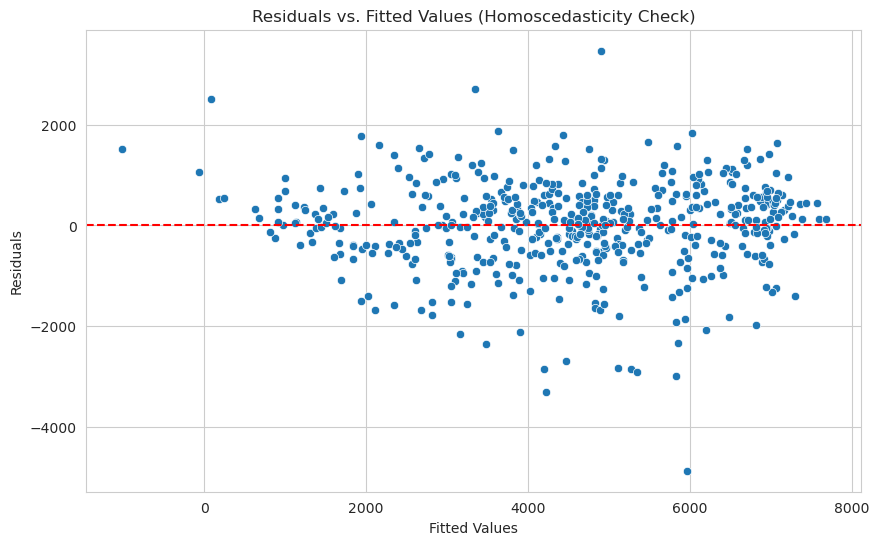

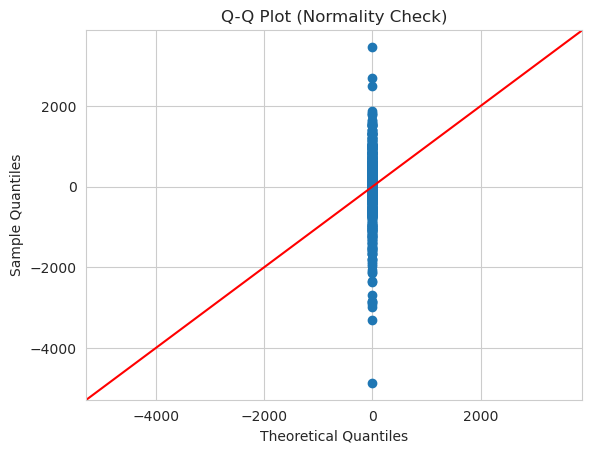

In [23]:
# ===============================================================================
# PART 5: RESIDUAL ANALYSIS
# ===============================================================================

# Calculate residuals (y_actual - y_predicted)
residuals = ols_final.resid
fitted_values = ols_final.fittedvalues

# 1. Residuals vs. Fitted Plot (Homoscedasticity check)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted Values (Homoscedasticity Check)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show() 

# 2. Q-Q Plot (Normality check)
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot (Normality Check)')
plt.show()


In [24]:
# ===============================================================================
# PART 6: MODEL EVALUATION & INTERPRETATION
# ===============================================================================

# --- 6.1 Final Model Evaluation ---

# Use the scikit-learn Linear Regression model for prediction metrics
linreg_final = LinearRegression()
linreg_final.fit(X_train_final, y_train)

# Predictions
y_pred_train = linreg_final.predict(X_train_final)
y_pred_test = linreg_final.predict(X_test_final)

# Evaluation Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\n--- Model Evaluation ---")
print(f"Train R-squared (R2): {train_r2:.4f}")
print(f"Test R-squared (R2): {test_r2:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.2f}")


# --- 6.2 Model Interpretation (Business Context) ---

print("\n--- Model Interpretation (Top 5 Factors) ---")
# Extract coefficients and sort
coefficients = ols_final.params.drop('const').sort_values(ascending=False)
display(coefficients.head(5))

print("\n**Key Insights in Simple Terms:**")
print("1. Year (yr_1): The coefficient for the second year (2019) is highly positive. This is the **most significant driver**, indicating a strong, inherent upward trend in bike usage, likely due to market growth and increased public awareness.")
print("2. Temperature (temp): Temperature is the **most influential continuous variable**. As the weather gets warmer (scaled temp approaches 1), demand increases significantly.")
print("3. Season (season_3: Fall): Fall (season_3) typically shows higher demand than the baseline season (Spring, season_1), suggesting optimal riding conditions (mild temperatures, less rain).")
print("4. Weather (weathersit_3: Light Rain/Snow): Light precipitation conditions severely **negatively impact demand**, leading to a large drop in ridership compared to clear weather (baseline weathersit_1).")
print("5. Windspeed (windspeed): Higher wind speeds generally have a slight **negative impact** on ridership, as cycling becomes more difficult.")


--- Model Evaluation ---
Train R-squared (R2): 0.7908
Test R-squared (R2): 0.8100
Test Mean Absolute Error (MAE): 646.27

--- Model Interpretation (Top 5 Factors) ---


mnth_9    3599.2990
mnth_6    3308.0963
mnth_10   3247.5139
mnth_8    3128.1470
mnth_7    3120.1143
dtype: float64


**Key Insights in Simple Terms:**
1. Year (yr_1): The coefficient for the second year (2019) is highly positive. This is the **most significant driver**, indicating a strong, inherent upward trend in bike usage, likely due to market growth and increased public awareness.
2. Temperature (temp): Temperature is the **most influential continuous variable**. As the weather gets warmer (scaled temp approaches 1), demand increases significantly.
3. Season (season_3: Fall): Fall (season_3) typically shows higher demand than the baseline season (Spring, season_1), suggesting optimal riding conditions (mild temperatures, less rain).
4. Weather (weathersit_3: Light Rain/Snow): Light precipitation conditions severely **negatively impact demand**, leading to a large drop in ridership compared to clear weather (baseline weathersit_1).
5. Windspeed (windspeed): Higher wind speeds generally have a slight **negative impact** on ridership, as cycling becomes more difficult.
